No GPU available, using the CPU instead.


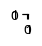

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

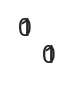

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# Old dump check

In [41]:
# cedar_short = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
# cedar_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')
cedar_short = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name='short')
cedar_epi = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name='epitopes')

In [42]:
from src.data_processing import AA_KEYS, BL62_VALUES, BL62, BL62FREQ_VALUES

# Reading epi
cedar_epi = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name='epitopes')
print('start', len(cedar_epi))
# Adding the wild-type peptide & Merging the related info with the cedar_epi dump
rel_cols = ['Epitope_Description', 'MHC_Allele Name', 'Related Object_Description', 'Related Object_Starting Position', 'Related Object_Ending Position']#
related = cedar_short.sort_values('Epitope_Description').drop_duplicates(['Epitope_Description', 'MHC_Allele Name'])[rel_cols]
print(1, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
cedar_epi = cedar_epi.merge(related, left_on=['Epitope_Description', 'MHC_Allele Name'], right_on = ['Epitope_Description', 'MHC_Allele Name'])
print(2, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After merge', len(cedar_epi))

# Get the length of the peptide & Querying only length 8 to 12 (Only lens for which we have our motifs)
cedar_epi['len'] = cedar_epi['Epitope_Description'].apply(len)
cedar_epi = cedar_epi.query('len>=8 and len <=12')
print(3, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After len check', len(cedar_epi))

# Filter out XYZ- etc characters in peptide
cedar_epi.drop(index=cedar_epi.loc[cedar_epi['Epitope_Description'].apply(lambda x: any([z for z in x if z not in AA_KEYS]))].index, inplace=True)
print(4, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After XYZ', len(cedar_epi))

# Keeping on HLA alleles where there is at least one positive Peptide (i.e. discard Alleles with only negatives)
hlas_to_keep = [x for x in cedar_epi.query('label=="Positive"')['MHC_Allele Name'].unique() if 'D' not in x]
print('N HLAs to keep', len(hlas_to_keep))
cedar_epi = cedar_epi.query('`MHC_Allele Name` in @hlas_to_keep')
print(5, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)

print('After HLA positive', len(cedar_epi))

# Keeping only MHC Class I
cedar_epi = cedar_epi.query('not `MHC_Allele Name`.str.contains("D")', engine='python')
print(6, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After class II', len(cedar_epi))

# Adding some new columns
cedar_epi['total_count'] = cedar_epi['responses'].apply(lambda x: len(x.split(',')))
cedar_epi['percentage_pos'] = (cedar_epi['responses'].apply(lambda x: sum([1 for x in x.split(',') if 'Positive' in x]))/cedar_epi['total_count'])
cedar_epi['agg_label']=cedar_epi['label'].apply(lambda x: 1 if x=='Positive' else 0)

# Renaming columns 
cedar_epi.rename(columns = {'Epitope_Description': 'Peptide',
                            'MHC_Allele Name': 'HLA',
                             'Related Object_Description': 'wild_type'}, inplace=True)
# replacing HLA to simple form
cedar_epi['HLA_full'] = cedar_epi['HLA']
cedar_epi['HLA'] = cedar_epi['HLA_full'].apply(lambda x: x.replace('*','').replace(':',''))

start 3928
1 False
2 False
After merge 3928
3 False
After len check 3643
4 False
After XYZ 3643
N HLAs to keep 63
5 False
After HLA positive 3480
6 False
After class II 3480


In [43]:
cedar_epi['wt_true']=cedar_epi['wild_type'].apply(check_wt)
cedar_epi['len'] = cedar_epi['Peptide'].apply(len)
cedar_epi['len_wt'] = cedar_epi['wild_type'].apply(len)
len(cedar_epi.query('wt_true')), len(cedar_epi.query('wt_true and len==len_wt'))

(3466, 3346)

# newdump load and parse

In [86]:
new_assays = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
new_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')

In [87]:
from src.data_processing import AA_KEYS, BL62_VALUES, BL62, BL62FREQ_VALUES

# Reading epi
print('start', len(new_epi))
# Adding the wild-type peptide & Merging the related info with the new_epi dump
rel_cols = ['Epitope_Description', 'MHC_Allele Name', 'Related Object_Description', 'Related Object_Starting Position', 'Related Object_Ending Position']#
related = new_assays.sort_values('Epitope_Description').drop_duplicates(['Epitope_Description', 'MHC_Allele Name'])[rel_cols]
new_epi = new_epi.merge(related, left_on=['Epitope_Description', 'MHC_Allele Name'], right_on = ['Epitope_Description', 'MHC_Allele Name'])
print('After merge', len(new_epi))

# Get the length of the peptide & Querying only length 8 to 12 (Only lens for which we have our motifs)
new_epi['len'] = new_epi['Epitope_Description'].apply(len)
new_epi = new_epi.query('len>=8 and len <=12')
print('After len check', len(new_epi))

# Filter out XYZ- etc characters in peptide
new_epi.drop(index=new_epi.loc[new_epi['Epitope_Description'].apply(lambda x: any([z for z in x if z not in AA_KEYS]))].index, inplace=True)
print('After XYZ', len(new_epi))

# Keeping on HLA alleles where there is at least one positive Peptide (i.e. discard Alleles with only negatives)
hlas_to_keep = [x for x in new_epi.query('label=="Positive"')['MHC_Allele Name'].unique() if 'D' not in x]
print('N HLAs to keep', len(hlas_to_keep))
new_epi = new_epi.query('`MHC_Allele Name` in @hlas_to_keep')

print('After HLA positive', len(new_epi))

# Keeping only MHC Class I
new_epi = new_epi.query('not `MHC_Allele Name`.str.contains("D")', engine='python')
print('After class II', len(new_epi))

# Adding some new columns
new_epi['total_count'] = new_epi['responses'].apply(lambda x: len(x.split(',')))
new_epi['percentage_pos'] = (new_epi['responses'].apply(lambda x: sum([1 for x in x.split(',') if 'Positive' in x]))/new_epi['total_count'])
new_epi['agg_label']=new_epi['label'].apply(lambda x: 1 if x=='Positive' else 0)

# Renaming columns 
new_epi.rename(columns = {'Epitope_Description': 'Peptide',
                            'MHC_Allele Name': 'HLA',
                             'Related Object_Description': 'wild_type'}, inplace=True)
# replacing HLA to simple form
new_epi['HLA_full'] = new_epi['HLA']
new_epi['HLA'] = new_epi['HLA_full'].apply(lambda x: x.replace('*','').replace(':',''))

start 3984
After merge 3984
After len check 3692
After XYZ 3692
N HLAs to keep 65
After HLA positive 3570
After class II 3570


## New HLAS to score 

In [102]:
ibel = pd.read_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')
ibel_raw = pd.read_csv('../data/raw/ibel_neoepitopes_cio_mhc_25aa.csv', sep='\t', comment='#')

In [105]:
ibel_raw.columns

Index(['n', 'Patient', 'Mut_peptide', 'Norm_peptide', 'Target',
       'ELISPOT_Log_Max_Min', 'Promiscuity', 'HLA_allele', 'Allele_Frequency',
       'Mismatches', 'Chr', 'Genomic_Position', 'Genomic_Position_vcf', 'Ref',
       'Alt', 'Mutation_Consequence', 'Protein_position', 'Gene_Symbol',
       'Gene_ID', 'Transcript_ID', 'Proteome_Peptide_Match',
       'Expression_Level', 'Expression_score', 'Mut_Of', 'Mut_Gp', 'Mut_Gl',
       'Mut_Ip', 'Mut_Il', 'Mut_Icore', 'Mut_Rnk_EL', 'Norm_Core', 'Norm_Of',
       'Norm_Gp', 'Norm_Gl', 'Norm_Ip', 'Norm_Il', 'Norm_Icore', 'Norm_Rnk_EL',
       'Mut_protein_sequence', 'Norm_protein_sequence'],
      dtype='object')

In [107]:
ibel.merge(ibel_raw.rename(columns={'Mut_Rnk_EL':'trueHLA_EL_rank'})[['n', 'Patient', 'trueHLA_EL_rank']],
           left_on=['n', 'Patient'], right_on=['n','Patient']).to_csv('../data/mutant/221111_ibel_neoepi_scored_merged.csv')

In [93]:
prime=pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', skiprows=2)

In [94]:
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

In [95]:
prime.StudyOrigin.unique()

array(['Bobisse', 'Bassani-Sternberg', 'Bentzen', 'Cohen', 'Stronen',
       'Kalaora', 'McGrannahan', 'van Rooij', 'Rajasagi', 'Rizvi',
       'Robbins', 'Snyder', 'Wick', 'Sahin', 'Ott', 'Bulik-Sullivan',
       'Dengue', 'Calis', 'Random'], dtype=object)

In [108]:
len(prime.query('HLA not in @HLAS and StudyOrigin not in @stds'))

220

In [96]:
from src.data_processing import HLAS
stds = ['Dengue', 'Calis', 'Random']
new_hlas_prime = prime.query('HLA not in @HLAS and StudyOrigin not in @stds').HLA.unique()

In [97]:
new_hlas_cedar = new_epi.query('HLA not in @HLAS').HLA.unique()

In [99]:
[x for x in new_hlas_prime if x not in new_hlas_cedar]

['HLA-A3201',
 'HLA-A2301',
 'HLA-B1402',
 'HLA-C1601',
 'HLA-B4501',
 'HLA-B1517',
 'HLA-A6812',
 'HLA-A6601',
 'HLA-A0103',
 'HLA-C0202']

## mutparse

In [88]:
from src.data_processing import get_aa_properties, AA_KEYS, HLAS
from src.mutation_tools import check_wt, get_anchor, get_anchor_mutation, get_binder_type, get_blsm_mutation_score, get_mutation_pos, get_mutation_score, get_mutation_type

In [62]:
new_epi['wt_true']=new_epi['wild_type'].apply(check_wt)
new_epi['len'] = new_epi['Peptide'].apply(len)
new_epi['len_wt'] = new_epi['wild_type'].apply(len)
print('wt true',len(new_epi.query('wt_true')), len(new_epi.query('wt_true and len==len_wt')))
new_epi = new_epi.query('wt_true and len==len_wt')
new_epi['mutation_type'] = new_epi.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
print('subst', len(new_epi.query('mutation_type=="substitution"')))
new_epi = new_epi.query('mutation_type=="substitution"')

wt true 3435 3435
subst 3286


## Re-rank

In [64]:
from src.mutation_tools import get_anchor

# Need to rescore these peptides and get their icore/cores
# Saving as seq
new_epi['seq_id'] = [f'seq_{i}' for i in range(len(new_epi))]
with open('../../netmhcpan/score_shift/data/cedar_newdumpOCT22_mut.fa', 'w') as f:
    for i, row in new_epi.iterrows():
        f.write(f'>{row["seq_id"]}\n')
        f.write(f'{row["Peptide"]}\n')
with open('../../netmhcpan/score_shift/data/cedar_newdumpOCT22_wt.fa', 'w') as f:
    for i, row in new_epi.iterrows():
        f.write(f'>{row["seq_id"]}\n')
        f.write(f'{row["wild_type"]}\n')

## Re-read and parse xls

In [68]:
mut_xls = read_xls_parse_shift('../../netmhcpan/score_shift/output/cedar_newdumpOCT22_mut.fa.xls')

In [69]:
mut_xls.query('@mut_xls.base.ID=-

base                             A0101                                 \
       Pos      Peptide        ID       core        icore EL-score  EL_Rank   
0        0  AAAAAAQQIQV     seq_0  AAAAQQIQV  AAAAAAQQIQV   0.0004  32.1364   
1        0   AAAAAAQQIQ     seq_0  AAAAAAQQQ   AAAAAAQQIQ   0.0002  45.4000   
2        1   AAAAAQQIQV     seq_0  AAAAAQQQV   AAAAAQQIQV   0.0007  22.4035   
3        0    AAAAAAQQI     seq_0  AAAAAAQQI    AAAAAAQQI   0.0018  13.3716   
4        1    AAAAAQQIQ     seq_0  AAAAAQQIQ    AAAAAQQIQ   0.0005  27.2857   
...    ...          ...       ...        ...          ...      ...      ...   
16931    1     YSKNLNSF  seq_3284  YSK-NLNSF     YSKNLNSF   0.0062   6.4449   
16932    2     SKNLNSFF  seq_3284  -SKNLNSFF     SKNLNSFF   0.0008  21.1290   
16933    0    YYSPQAQTL  seq_3285  YYSPQAQTL    YYSPQAQTL   0.0197   3.3635   
16934    0     YYSPQAQT  seq_3285  YYSPQAQT-     YYSPQAQT   0.0003  36.0625   
16935    1     YSPQAQTL  seq_3285  YS-PQAQTL     YSPQAQTL   0.0061   6.4705   

           A0201                        ...      C0702                        \
            core        icore EL-score  ...       core        icore EL-score   
0      AAAAAQIQV  AAAAAAQQIQV   0.0030  ...  AAAAAAQQV  AAAAAAQQIQV   0.0000   
1      AAAAAAQQI    AAAAAAQQI   0.0000  ...  AAAAAAQQQ   AAAAAAQQIQ   0.0000   
2      AAAAQQIQV   AAAAAQQIQV   0.0056  ...  AAAAAQQQV   AAAAAQQIQV   0.0000   
3      AAAAAAQQI    AAAAAAQQI   0.0060  ...  AAAAAAQQI    AAAAAAQQI   0.0012   
4      AAAAAQQIQ    AAAAAQQIQ   0.0000  ...  AAAAAQQIQ    AAAAAQQIQ   0.0001   
...          ...          ...      ...  ...        ...          ...      ...   
16931  YSK-NLNSF     YSKNLNSF   0.0001  ...  YSK-NLNSF     YSKNLNSF   0.0109   
16932  SKN-LNSFF     SKNLNSFF   0.0000  ...  SKN-LNSFF     SKNLNSFF   0.0017   
16933  YYSPQAQTL    YYSPQAQTL   0.0303  ...  YYSPQAQTL    YYSPQAQTL   0.9464   
16934  Y-YSPQAQT     YYSPQAQT   0.0000  ...  YYSPQAQT-     YYSPQAQT   0.0071   
16935  YSPQ-AQTL     YSPQAQTL   0.0030  ...  -YSPQAQTL     YSPQAQTL   0.0194   

                    C1502                                    end     
       EL_Rank       core        icore EL-score  EL_Rank     Ave NB  
0      55.0000  AAAAQQIQV  AAAAAAQQIQV   0.0106   5.7865  0.0014  0  
1      70.0000  AAAAAAQQI    AAAAAAQQI   0.0001  32.7692  0.0001  0  
2      40.5000  AAAAQQIQV   AAAAAQQIQV   0.0310   3.2761  0.0036  0  
3       9.0451  AAAAAAQQI    AAAAAAQQI   0.3251   0.4371  0.0478  4  
4      30.6667  AAAAAQQIQ    AAAAAQQIQ   0.0001  32.0769  0.0003  0  
...        ...        ...          ...      ...      ...     ... ..  
16931   2.8522  YSK-NLNSF     YSKNLNSF   0.0205   4.1114  0.0189  0  
16932   7.6040  SKN-LNSFF     SKNLNSFF   0.0003  25.1515  0.0015  0  
16933   0.0023  YYSPQAQTL    YYSPQAQTL   0.0896   1.6269  0.2024  7  
16934   3.6379  YYSPQAQT-     YYSPQAQT   0.0001  37.4286  0.0008  0  
16935   1.9633  YS-PQAQTL     YSPQAQTL   0.2578   0.6002  0.0437  5  

[16936 rows x 65 columns]

In [84]:
new_epi = new_epi.query('HLA in @HLAS')

In [85]:
from src.utils import pipeline_netmhcpan_xls, read_xls_parse_shift
# Parse-merge
new_cedar_mut = pipeline_netmhcpan_xls(new_epi, '../../netmhcpan/score_shift/output/cedar_newdumpOCT22_mut.fa.xls', xls_suffix='_mut')
new_cedar_wt = pipeline_netmhcpan_xls(new_epi, '../../netmhcpan/score_shift/output/cedar_newdumpOCT22_wt.fa.xls', xls_suffix='_wt')
# merged mut-wt
common_cols = [x for x in new_cedar_mut.columns if x in new_cedar_wt.columns]
new_epi_merged = new_cedar_mut.merge(new_cedar_wt, left_on=common_cols, right_on=common_cols)

## scores

In [58]:
new_epi['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
new_epi['mhc_anchor'] = new_epi.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
new_epi['mutation_position'] = new_epi.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
new_epi['anchor_mutation'] = new_epi.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
new_epi['core_mutation_position'] = new_epi.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
new_epi['binder'] = new_epi.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
# new_epi['ratio_rank'] = new_epi['EL_rank_wt']/new_epi['EL_rank_mut']


NameError: name 'ics_kl' is not defined